In [63]:
from info import * 
from preprocess import *
import utils

# automatic unit testing
import sys
sys.path.insert(0, '/Users/matty_gee/Dropbox/Projects/social_navigation_task/tests')
%run -i '../tests/test_behavior.py'

...........
----------------------------------------------------------------------
Ran 11 tests in 0.349s

OK


In [55]:
# run it 
compute = ComputeBehavior(file=fake_data(), weight_types=False, decision_types=False, coord_types=False, out_dir=False)
compute.run()
compute.behavior

,dimension,char_role_num,char_decision_num,button_press,decision,affil,power,affil_coord,power_coord,affil_mean,...,neu3d_angle,pov3d_angle,char_decision_num,perimeter,area,volume,Q1_overlap,Q2_overlap,Q3_overlap,Q4_overlap
0,affil,1,1,1,-1,-1.0,0.0,-1.0,0.0,-1.000000,...,2.070143,1.570796,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,affil,1,2,1,1,1.0,0.0,0.0,0.0,0.000000,...,1.570796,1.570796,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,affil,1,3,1,-1,-1.0,0.0,-1.0,0.0,-0.333333,...,2.158799,1.570796,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,power,1,4,1,-1,0.0,-1.0,-1.0,-1.0,-0.333333,...,2.008945,1.655751,4,3.414214,0.5,0.333333,0.000000,0.000000,1.000000,0.000000
4,affil,2,1,1,-1,-1.0,0.0,-1.0,0.0,-1.000000,...,2.070143,1.570796,1,3.414214,0.5,0.333333,0.000000,0.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,power,4,12,1,-1,0.0,-1.0,2.0,-4.0,0.333333,...,1.107149,2.356194,12,23.495798,33.0,192.333333,0.022727,0.431818,0.356061,0.189394
59,power,3,9,2,1,0.0,1.0,-3.0,4.0,-0.600000,...,2.137266,1.199030,9,24.368955,35.5,201.666667,0.021127,0.471831,0.330986,0.176056
60,power,3,10,1,1,0.0,1.0,-3.0,5.0,-0.600000,...,2.080700,1.091989,10,25.718674,38.0,218.000000,0.019737,0.506579,0.309211,0.164474
61,power,3,11,1,-1,0.0,-1.0,-3.0,4.0,-0.600000,...,2.204131,1.158611,11,25.718674,38.0,220.000000,0.019737,0.506579,0.309211,0.164474


In [56]:
xlsxs = ['../data/example_subject/snt_583_narrative_data.xlsx']
compute = ComputeBehavior(file=xlsxs[0], weight_types=True, decision_types=True, coord_types=True, out_dir=False)
compute.run()
compute.behavior

//anaconda3/envs/social_navigation_task/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,scene_num,decision_num,char_decision_num,dimension,char_role_num,onset,button_press,decision,reaction_time,affil,...,pov_distance_prev_exponential-decay_cf,neu3d_angle_prev_exponential-decay_cf,pov3d_angle_prev_exponential-decay_cf,perimeter_prev_exponential-decay_cf,area_prev_exponential-decay_cf,volume_prev_exponential-decay_cf,Q1_overlap_prev_exponential-decay_cf,Q2_overlap_prev_exponential-decay_cf,Q3_overlap_prev_exponential-decay_cf,Q4_overlap_prev_exponential-decay_cf
0,1,1,1,affil,1,116.830780,2,-1,5.362730,-1.0,...,6.000000,1.570796,1.570796,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,2,affil,1,131.725189,3,-1,3.980087,-1.0,...,5.083333,1.030377,1.570796,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3,3,affil,1,151.223053,2,-1,4.633758,-1.0,...,6.076389,2.158799,1.570796,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,4,4,power,1,176.024872,2,-1,3.823508,0.0,...,6.986690,2.214297,1.570796,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,5,1,affil,2,198.424835,2,-1,3.199085,-1.0,...,6.000000,1.570796,1.570796,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,17,59,12,power,4,1571.144531,3,-1,4.067173,0.0,...,5.316943,1.071277,1.208616,17.166944,20.005733,127.573179,0.137421,0.200238,0.46715,0.195191
59,18,60,9,power,3,1591.643066,2,1,5.744123,0.0,...,5.518317,1.103575,1.729576,17.166944,20.005733,127.573179,0.137421,0.200238,0.46715,0.195191
60,18,61,10,power,3,1608.522217,2,1,2.872706,0.0,...,4.659988,0.795505,1.866724,17.166944,20.005733,133.415758,0.137421,0.200238,0.46715,0.195191
61,19,62,11,power,3,1629.921509,2,1,3.280995,0.0,...,4.532352,0.561806,1.776254,17.166944,20.005733,134.758351,0.137421,0.200238,0.46715,0.195191


## Visualize the different decision weighting schemes...

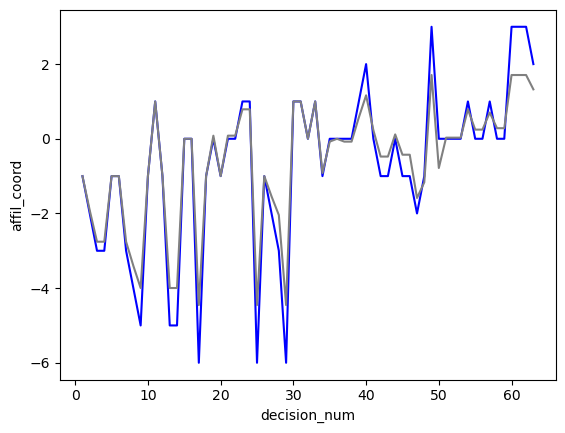

In [68]:
import seaborn as sns
# plot against time
sns.lineplot(data=behavior, x="decision_num", y="affil_coord", color='blue')
# sns.lineplot(data=behavior, x="decision_num", y="affil_coord_cf", color='grey')
sns.lineplot(data=behavior, x="decision_num", y="affil_coord_exponential-decay", color='grey')
# sns.lineplot(data=behavior, x="decision_num", y="power_coord", color='red')
plt.show()

## Tests to incorporate

In [6]:
import random
compute = ComputeBehavior(file_path=None)

rand_decs = np.array([random.choice([-1,1]) for _ in range(10)]).reshape(-2,2)
resp_mask = rand_decs != 0
coords = np.cumsum(rand_decs, axis=0)    
cum_mean, cum_count = compute.cumulative_mean(rand_decs, resp_mask)
cum_mean[-1,:]


array([-0.2,  0.6])

In [7]:
coords[-1,:] / cum_count[-1,:]

array([-0.2,  0.6])

In [55]:
# testing the make_3d function:

U = np.random.randint(1,10, size=(3,2)) # all the outputs should have this shape
V = np.random.randint(1,10, size=(2,))
ori = np.array([[0,0]])

## funciton: 
if V.ndim == 2:   V = V[0]
if ori.ndim == 1: ori = ori[np.newaxis]

num = np.arange(1, len(U) + 1)[:,np.newaxis]
U   = np.concatenate([U, num], axis=1) # changes w/ num of interactions
V   = np.repeat(np.hstack([V, len(U)])[np.newaxis], len(U), axis=0) # fixed
ori = np.concatenate([np.repeat(ori, len(U), axis=0), num], axis=1) # changes w/ num of interactions   
# ori & U should have z-axis coordinates that increase sequentially; V should have a fixed z-axis coordinate 

In [2]:
# TODO: concatenate the columns in one go for the df

from pathlib import Path 
import csv
import numpy as np
import pandas as pd
import os
import sys
import scipy.spatial

sys.path.insert(0, '../../../toolbox/toolbox')
from circ_stats import * 
from matrices import *

# should probably import toolbox so circ_stats etc is available...

In [8]:

def by_character(variable):
    ''' return variable name for each character '''
    return [variable + '_' + character_roles[c] for c in range(5)]
    

def chars_df(df, var_name):
    ''' subset a df with the different character values for a variable'''
    return df[[var_name + '_' + cr for cr in character_roles]]


def get_decision_sequence(df):
    ''' grab decisions from a summary df'''
    return df.loc[0, ['decisions_' + "{:02d}".format(t+1) for t in range(63)]]


def repeat_array_cols(X, repeats=2):
    return np.transpose([X] * repeats)


# Log to more detailed xlsx

In [14]:
# file_path = str(Path(f'{pkg_dir}/../data/example_subject/snt_18001.log'))
# experimenter = 'KB'
# parse_log(file_path, experimenter, output_timing=True, out_dir=None)

# Behavior

In [87]:
file_path = Path(f'{pkg_dir}/../data/example_subject/snt_18001.xlsx')
compute_behavior(file_path, out_dir=f'{pkg_dir}/../data/example_subject/')

# for RDVs

In [217]:
from itertools import compress, product, combinations 
def combos(arr, k=2):
    """ 
        arr: np.array to get combos from
        r: num of combos
    """
    return list(combinations(arr, k))

In [242]:
file_path = Path(f'{pkg_dir}/../data/example_subject/snt_18001_behavior.xlsx')
compute_rdvs(file_path, metric='euclidean', out_dir=None)

# summarize all subjs

In [293]:
file_paths = [f'{pkg_dir}/../data/example_subject/snt_18001_behavior.xlsx', f'{pkg_dir}/../data/example_subject/snt_18001_behavior.xlsx']
out_dir=f'{pkg_dir}/preprocessed_behavior/'

summarize_behavior(file_paths, out_dir=out_dir)

/Users/matthew/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


/Users/matthew/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
